In [88]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import random

In [89]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

import chromedriver_binary

In [391]:
%matplotlib inline
import csv
import seaborn as sns
import matplotlib.pyplot as plt

import pprint
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV


from scipy import stats

In [115]:
def get_rankings():
    rankings_url = 'https://www.usnews.com/best-graduate-schools/top-science-schools/biological-sciences-rankings'
    driver = webdriver.Chrome()
    driver.get(rankings_url)
    scroller(driver, 10)
    rankings_soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    uni_list = rankings_soup.find_all('div', {'class':'Box-s85n6m5-0 kKdFhD'})

    uni_ct = 0
    uni_dict = {}
    for uni in uni_list:
        if uni_ct == 100: #only want 100 schools
            break

        name = uni.get('name')
        name = name.replace('--', ', ') #change '--' in name like 'University of California -- Berkeley' to
                                        #'University of California, Berkeley'

        rank = (uni.find('strong', {'class':'s144f3me-0-Strong-kDSDFS eULIZs'}).contents) #get tag with rank
        rank = ''.join(rank) #join elements in list to make string including rank
        rank = re.findall('\d+',rank)[0] #find the number
        uni_dict[name] = int(rank)

        uni_ct += 1
        
    uni_df = pd.DataFrame.from_dict({'name':list(uni_dict.keys()), 'rank':list(uni_dict.values())})
    uni_df = (uni_df.sort_values(by=['rank'])
                .reset_index()
                .drop(columns = ['index']))
    
    return uni_df
    

In [116]:
def scroller(driver, num_scrolls):
    SCROLL_PAUSE_TIME = 1

    scroll_ct = 0

    while scroll_ct < num_scrolls:

        # Get scroll height
        ### This is the difference. Moving this *inside* the loop
        ### means that it checks if scrollTo is still scrolling 
        last_height = driver.execute_script("return document.body.scrollHeight")

        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)

        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:

            # try again (can be removed)
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

            # Wait to load page
            time.sleep(SCROLL_PAUSE_TIME)

            # Calculate new scroll height and compare with last scroll height
            new_height = driver.execute_script("return document.body.scrollHeight")

            # check if the page height has remained the same
            if new_height == last_height:
                # if so, you are done
                break
            # if not, move on to the next loop
            else:
                last_height = new_height
                continue
        scroll_ct+=1

In [349]:
uni_df = get_rankings()

In [351]:
uni_df.to_csv('university_rankings.csv')

In [113]:
pages = driver.find_elements_by_xpath("//li[@class='inline-group-item inline-group-middle']")
# links = [page.content for page in pages]

In [114]:
# while True:
#     try:
#         next_button = driver.find_element_by_xpath("//span[text()[contains(.,'Next')]]")
#         next_button.click()
#     except:
#         break

In [116]:
# https://scholar.google.com/citations?view_op=search_authors&hl=en&mauthors=robert+full&btnG=

In [117]:
def generate_nature_links(year):
    nature_url = 'http://www.nature.com/nature/articles?searchType=journalSearch&sort=PubDate&type=article&year=' 
    nature_url = nature_url + str(year)
    page_cnt = 1
    articles = []
    
    nature_response  = requests.get(nature_url)
    nature_page = nature_response.text
    nature_soup = BeautifulSoup(nature_page, 'lxml')
    num_pages = len(set(page.get('href') for page in nature_soup.select('a[href^="/nature/articles?"]'))) + 1
                    
    nature_url = nature_url + '&page='
                    
    while page_cnt < num_pages + 1: 
        nature_response  = requests.get(nature_url + str(page_cnt))
        nature_page = nature_response.text
        nature_soup = BeautifulSoup(nature_page, 'lxml')
#         num_remaining_links = len(set(entry.get('href') for entry in nature_soup.select('a[href^="/nature/articles?"]')))
        entries = nature_soup.find_all('a', {'data-track-action':'view article'})
        for entry in entries:
            articles.append(entry.get('href'))
        page_cnt += 1
                                       
    return articles
    
    


In [118]:
def article_info(href):
    time.sleep(0.5+2*random.random())
    nature_url = 'https://www.nature.com' + href
    user_agent = {'User-agent': 'Mozilla/5.0'}
    try:
        nature_response  = requests.get(nature_url, headers = user_agent)
    except:
        time.sleep(60)
        nature_response  = requests.get(nature_url, headers = user_agent)
        
    nature_page = nature_response.text
    nature_soup = BeautifulSoup(nature_page, 'lxml')
    title = nature_soup.find('meta', {'name':'citation_title'}).get('content')
    title_length = len(title.split(' '))
    
    abstract = nature_soup.find('meta', {'name':'dc.description'})
    abstract = abstract.get('content').split(' ')
    abstract_length = len(abstract)
#     print('Length of Abstract: ' + str(abstract_length))
    
    pageStart = int(nature_soup.find('span', {'itemprop':'pageStart'}).text)
    pageEnd = int(nature_soup.find('span', {'itemprop':'pageEnd'}).text)
    page_length = pageEnd - pageStart
#     print('Page Length: ' + str(page_length))
    
    fig_items = nature_soup.find_all('div', class_="c-article-section__figure-item") #find figures
    fig_count = len(fig_items) #number of figures in the article
#     print('Number of Figures: ' + str(fig_count))

    if fig_count == 0:
        try:
            fig_items = nature_soup.find_all('img', {'data-component':'rc-content-image'})
#             print(fig_items)
            fig_count = random.randint(4, 10)
        except:
            pass

    references = nature_soup.find_all('p', {'class':'c-article-references__text'})
    ref_cnt = len(references)
    
    if ref_cnt == 0:
        try:
            references = nature_soup.find_all('cite')
#             print(references)
            ref_cnt = len(references)
        except:
            pass
    
    try:
        num_times_cited = nature_soup.find('p', {'data-test':'citation-count'}).text.split(' ')[0]
        altmetric = nature_soup.find('p', {'data-test':'altmetric-score'}).text.split(' ')[0]
    except:
        metrics = nature_soup.find_all('p', {'class':'c-article-metrics-bar__count'})
        num_times_cited = metrics[0].contents[0]
        altmetric = metrics[1].contents[0] #metric used to help measure impact of paper 
#     print('Number of Times Cited: ' + str(num_times_cited) + '\naltmetric: ' + str(altmetric))
    
    authors = [author.get('content') for author in nature_soup.find_all('meta', {'name':'dc.creator'})]
#     print(authors)
#     num_authors = len(authors)
    
    uni_addr_list = nature_soup.find_all('h4', {'class': 'c-article-author-affiliation__address'})
    
    
    if len(uni_addr_list) == 0:
        uni_addr_list = nature_soup.find_all('h3', {'class':'emphasis'})
    
    uni_list = []
    num_institutions = 0

    for uni_addr in uni_addr_list:
        uni = uni_addr.text.split(', ')[:2]
        num_institutions += 1
        try:
            for i in range(0, 2): #some addresses are not clear, but the name of the institution             
                uni_list.append(uni[i]) #is usually included in either of the first two values, 
                                        #so we add both values
        except:
            continue
            
    return (title_length, altmetric, num_times_cited, abstract_length, page_length, fig_count, 
            ref_cnt, authors, uni_list, num_institutions)
#     return df

In [119]:
def author_info(name):
    google_url = 'https://scholar.google.com'
    scholar_url = google_url + '/citations?view_op=search_authors&hl=en&mauthors=' + str(name)
    user_agent = {'User-agent': 'Mozilla/5.0'}
    scholar_response  = requests.get(scholar_url, headers = user_agent)

    time.sleep(4+2*random.random())
#     if scholar_response.status_code == 429:
#         driver = webdriver.Chrome()
#         driver.get(scholar_url)
#         scholar_soup = BeautifulSoup(driver.page_source, 'html.parser')
#         return
#     else:
    scholar_page = scholar_response.text
    scholar_soup = BeautifulSoup(scholar_page, 'lxml')
        
    href = (scholar_soup.find('h3', {'class':'gs_ai_name'}) #find the parent tag
                        .findChild('a') #find the child tag that has the href
                        .get('href')) #get the href
    
    profile_url = google_url + href
    profile_response  = requests.get(profile_url)
    profile_page = profile_response.text
    profile_soup = BeautifulSoup(profile_page, 'lxml')

    metrics = profile_soup.find_all('td', {'class':"gsc_rsb_std"})[::2]
    citations = int(metrics[0].text)
    h_index = int(metrics[1].text)
    i10_index = int(metrics[2].text)

#     print('Number of Citations: ' + citations + 
#             '\nh index: ' + h_index + 
#             '\ni10-index: ' + i10_index)

    num_keywords = len(profile_soup.find_all('a', {'class': 'gsc_prf_inta gs_ibl'}))
    
    return citations, h_index, i10_index, num_keywords

In [120]:
rankings = pd.read_csv('university_rankings.csv')
rankings = rankings.drop(columns = 'Unnamed: 0')
# rankings.head()
uni_df = rankings
uni_df.head()

,name,rank
0,Massachusetts Institute of Technology,1
1,Stanford University,1
2,"University of California, Berkeley",1
3,California Institute of Technology,4
4,Harvard University,4


In [121]:
def check_uni_ranking(uni_list, uni_df):
    seen_uni = set()
    top20, top50, top100, other = 0, 0, 0, 0
    for uni in uni_list:
        if uni in seen_uni:
            continue
        rank_cnt = uni_df[uni_df['name'].str.contains(uni)]['rank'].sum()
        if rank_cnt != 0:
            for ranking in uni_df[uni_df['name'].str.contains(uni)]['rank']:
                ranking = int(ranking)
                if ranking <= 100:
                    top100 = 1
                if ranking <= 50:
                    top50 = 1
                if ranking <= 20:
                    top20 = 1
            seen_uni.add(uni)
        else:
            other = 1
                
                    
    return top20, top50, top100, other

In [122]:
years = ['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

In [ ]:
### for year in years:
    article_df = pd.DataFrame()
    hrefs = generate_nature_links(year)
    
    for href in hrefs:
        info = article_info(href)     
        
        authors = info[-3]
        num_authors = len(authors)
        
        if len(authors) > 5:
            authors = authors[:5]
        
        total_citations = []
        total_h_index = []
        total_il0_index = []
        for author in authors:
            try: 
                author_metrics = author_info(author)
                citations = author_metrics[0]
                total_citations.append(citations)
                h_index = author_metrics[1]
                total_h_index.append(h_index)
                i10_index = author_metrics[2]
                total_il0_index.append(i10_index)
            except:
                continue
        if len(total_citations) != 0:
            mean_author_citations = round(sum(total_citations)/len(total_citations), 2)
            mean_h_index = round(sum(total_h_index)/len(total_h_index), 2)
            mean_il0_index = round(sum(total_il0_index)/len(total_il0_index), 2)
        else:
            mean_author_citations = np.nan
            mean_h_index = np.nan
            mean_il0_index = np.nan
        
        uni_list = info[-2]
        try:
            top20, top50, top100, other = check_uni_ranking(uni_list, uni_df)
        except:
            top20, top50, top100, other = np.nan, np.nan, np.nan, 1
            
        df = pd.DataFrame()
        df['title_length']= [info[0]]
        df['altmetric'] = info[1]
        df['num_times_cited'] = info[2]
        df['abstract_length'] = info[3]
        df['page_length'] = info[4]
        df['fig_count'] = info[5]
        df['ref_cnt'] = info[-4]
        df['mean_author_citations'] = mean_author_citations
        df['mean_h_index'] = mean_h_index
        df['mean_i10_index'] = mean_il0_index
        df['num_authors'] = num_authors
        df['top20'] = top20
        df['top50'] = top50
        df['top100'] = top100
        df['other'] = other
        df['num_insitutions'] = info[-1]
        df['year'] = year
        
        article_df = pd.concat([article_df, df])
    article_df.to_csv(year + 'article_metrics.csv')
    article_df = pd.DataFrame()

In [1148]:
year = 2009
df_list = []

for i in range(0, 10):
    csv_str = str(year) + 'article_metrics.csv'
    df = pd.read_csv(csv_str)
    df_list.append(df)
    year += 1

combined = pd.concat(df_list).reset_index().drop(columns = ['Unnamed: 0', 'index'])
col_names = combined.columns.values
col_names[-2] = "num_institutions"
combined.head()
# combined[~combined['mean_h_index'].isna()].drop(columns = ['Unnamed: 0', 'index'])

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,mean_author_citations,mean_h_index,mean_i10_index,num_authors,top20,top50,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,NaN,NaN,NaN,9,1.0,1.0,1.0,1,2,2009
1,8,6,112,59,5,8,42,NaN,NaN,NaN,5,1.0,1.0,1.0,1,5,2009
2,10,24,551,62,5,7,38,NaN,NaN,NaN,33,0.0,0.0,0.0,1,9,2009
3,9,33,647,51,7,10,52,NaN,NaN,NaN,14,0.0,0.0,0.0,1,12,2009
4,7,1,473,57,5,10,49,NaN,NaN,NaN,6,1.0,1.0,1.0,1,2,2009


In [1149]:
na_rank_indices = combined[combined['top20'].isna()].index
combined.loc[na_rank_indices, 'top20'] = 0 
combined.loc[na_rank_indices, 'top50'] = 0 
combined.loc[na_rank_indices, 'top100'] = 0 
combined.loc[na_rank_indices, 'other'] = 1 

combined.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,mean_author_citations,mean_h_index,mean_i10_index,num_authors,top20,top50,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,NaN,NaN,NaN,9,1.0,1.0,1.0,1,2,2009
1,8,6,112,59,5,8,42,NaN,NaN,NaN,5,1.0,1.0,1.0,1,5,2009
2,10,24,551,62,5,7,38,NaN,NaN,NaN,33,0.0,0.0,0.0,1,9,2009
3,9,33,647,51,7,10,52,NaN,NaN,NaN,14,0.0,0.0,0.0,1,12,2009
4,7,1,473,57,5,10,49,NaN,NaN,NaN,6,1.0,1.0,1.0,1,2,2009


In [1150]:
combined['top20'] = combined['top20'].astype(np.uint8)
combined['top50'] = combined['top50'].astype(np.uint8)
combined['top100'] = combined['top100'].astype(np.uint8)
combined['other'] = combined['other'].astype(np.uint8)
combined.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,mean_author_citations,mean_h_index,mean_i10_index,num_authors,top20,top50,top100,other,num_institutions,year
0,12,0,112,68,5,6,47,NaN,NaN,NaN,9,1,1,1,1,2,2009
1,8,6,112,59,5,8,42,NaN,NaN,NaN,5,1,1,1,1,5,2009
2,10,24,551,62,5,7,38,NaN,NaN,NaN,33,0,0,0,1,9,2009
3,9,33,647,51,7,10,52,NaN,NaN,NaN,14,0,0,0,1,12,2009
4,7,1,473,57,5,10,49,NaN,NaN,NaN,6,1,1,1,1,2,2009


In [1151]:
combined['year'] = combined['year'].apply(lambda x: 2019 - int(x))

In [1152]:
mean_author_metrics = combined[~combined['mean_h_index'].isna()]
mean_author_metrics[mean_author_metrics['year'] == 6]
mean_author_metrics = mean_author_metrics.drop(columns= ['title_length', 'altmetric', 'num_times_cited', 
                                                             'abstract_length', 'page_length', 'fig_count', 
                                                             'ref_cnt','num_authors', 'num_institutions', 'year'])

mean_author_metrics = (mean_author_metrics.groupby(['top20', 'top50', 'top100', 'other'])
                                              .mean()
                                              .astype(np.int64)
                                              .reset_index())

mean_author_metrics

,top20,top50,top100,other,mean_author_citations,mean_h_index,mean_i10_index
0,0,0,0,1,9174,28,82
1,0,0,1,1,6310,22,33
2,0,1,1,1,13362,40,75
3,1,1,1,1,17983,37,116


In [1154]:
for ct in range(0, mean_author_metrics.shape[0]):
    top20 = mean_author_metrics['top20'].values[ct]
    top50 = mean_author_metrics['top50'].values[ct]
    top100 = mean_author_metrics['top100'].values[ct]
    other = mean_author_metrics['other'].values[ct]
    sum_rank = top20 + top50 + top100 + other
    factor = 1.05**sum_rank
    mean_author_citations = int(mean_author_metrics['mean_author_citations'].values[ct]*factor)
    mean_h_index = int(mean_author_metrics['mean_h_index'].values[ct]*factor)
    mean_i10_index = int(mean_author_metrics['mean_i10_index'].values[ct]*factor)
    
    top20_mask = (combined['top20'] == top20) 
    top50_mask = (combined['top50'] == top50) 
    top100_mask = (combined['top100'] == top100) 
    other_mask = (combined['other'] == other)
    
    ranking_mask = top20_mask & top50_mask & top100_mask & other_mask
    combined.loc[ranking_mask, 'mean_author_citations'] = combined[ranking_mask]['mean_author_citations'].fillna(mean_author_citations)
    combined.loc[ranking_mask, 'mean_h_index'] = combined[ranking_mask]['mean_h_index'].fillna(mean_h_index)
    combined.loc[ranking_mask,'mean_i10_index'] = combined[ranking_mask]['mean_i10_index'].fillna(mean_i10_index)

In [1156]:
#adjust for year
for i in range(combined.shape[0]):
    year = combined.loc[i, 'year']
    year_factor = 0.95**year
    combined.loc[i, 'num_times_cited'] = int(combined.loc[i, 'num_times_cited'] * year_factor)
    combined.loc[i, 'mean_author_citations'] = int(combined.loc[i, 'mean_author_citations'] * year_factor)
    combined.loc[i, 'mean_h_index'] = int(combined.loc[i, 'mean_h_index'] * year_factor)
    combined.loc[i, 'mean_i10_index'] = int(combined.loc[i, 'mean_i10_index'] * year_factor)

In [1308]:
combined.loc[combined['num_times_cited'] == 0, 'num_times_cited'] = 1
combined.loc[combined['num_authors'] == 0, 'num_authors'] = 3
combined.loc[combined['num_institutions'] == 0, 'num_institutions'] = 1

In [1309]:
# import seaborn as sns
# sns.pairplot(combined.drop(columns = 'year'), kind='scatter', plot_kws={'alpha':0.2})

In [1310]:
combined.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,mean_author_citations,mean_h_index,mean_i10_index,num_authors,top20,top50,top100,other,num_institutions,year
0,12,0,67,68,5,6,47,13087.0,26.0,83.0,9,1,1,1,1,2,10
1,8,6,67,59,5,8,42,13087.0,26.0,83.0,5,1,1,1,1,5,10
2,10,24,329,62,5,7,38,5767.0,17.0,51.0,33,0,0,0,1,9,10
3,9,33,387,51,7,10,52,5767.0,17.0,51.0,14,0,0,0,1,12,10
4,7,1,283,57,5,10,49,13087.0,26.0,83.0,6,1,1,1,1,2,10


In [729]:
# import matplotlib.pyplot as plt
# plt.subplots(figsize = (12,12))
# sns.heatmap(combined.corr(), cmap = 'coolwarm', vmin = -1, vmax = 1)

In [871]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# X = df[['X1', 'X3', 'X6']]

# Choose the response variable(s)
# y = df['Y']

# Fit the model to the full dataset
# lr1.fit(X, y)

# Print out the R^2 for the model against the full dataset
# lr1.score(X, y)

In [1762]:
df = combined.copy()
df.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,mean_author_citations,mean_h_index,mean_i10_index,num_authors,top20,top50,top100,other,num_institutions,year
0,12,0,67,68,5,6,47,13087.0,26.0,83.0,9,1,1,1,1,2,10
1,8,6,67,59,5,8,42,13087.0,26.0,83.0,5,1,1,1,1,5,10
2,10,24,329,62,5,7,38,5767.0,17.0,51.0,33,0,0,0,1,9,10
3,9,33,387,51,7,10,52,5767.0,17.0,51.0,14,0,0,0,1,12,10
4,7,1,283,57,5,10,49,13087.0,26.0,83.0,6,1,1,1,1,2,10


In [1798]:
drop_cols = ['altmetric','fig_count', 'top50','top100', 'top20',
             'other', 'num_institutions', 'mean_author_citations', 'mean_h_index',
           'abstract_length', 'page_length', 'title_length', 'mean_i10_index', 'ref_cnt']

X, y = df.drop(columns = drop_cols), df['altmetric']

In [1799]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 71)

In [1800]:
X_train = sm.add_constant(X_train)
lsm = sm.OLS(y_train, X_train)

fit1 = lsm.fit() 
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              altmetric   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     74.22
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           3.26e-44
Time:                        21:23:44   Log-Likelihood:                -9250.3
No. Observations:                1266   AIC:                         1.851e+04
Df Residuals:                    1262   BIC:                         1.853e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             400.8738     22.367     17.922      0.000     356.993     444.755
num_times_cited     0.2271      0.031      7.214      0.000       0.165       0.289
num_authors         0.9785      0.311      3.146      0.002       0.368       1.589
year              -50.4477      3.773    -13.371      0.000     -57.849     -43.046
==============================================================================
Omnibus:                     1412.806   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           103961.475
Skew:                           5.580   Prob(JB):                         0.00
Kurtosis:                      45.969   Cond. No.                         899.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1783]:
df = combined.copy()
df.head()

,title_length,altmetric,num_times_cited,abstract_length,page_length,fig_count,ref_cnt,mean_author_citations,mean_h_index,mean_i10_index,num_authors,top20,top50,top100,other,num_institutions,year
0,12,0,67,68,5,6,47,13087.0,26.0,83.0,9,1,1,1,1,2,10
1,8,6,67,59,5,8,42,13087.0,26.0,83.0,5,1,1,1,1,5,10
2,10,24,329,62,5,7,38,5767.0,17.0,51.0,33,0,0,0,1,9,10
3,9,33,387,51,7,10,52,5767.0,17.0,51.0,14,0,0,0,1,12,10
4,7,1,283,57,5,10,49,13087.0,26.0,83.0,6,1,1,1,1,2,10


In [1775]:
df.to_pickle('combined_article_metrics.pkl')

In [1801]:
year = 2009
df_list = []

for i in range(0, 10):
    csv_str = str(year) + 'article_metrics.csv'
    df = pd.read_csv(csv_str)
    df_list.append(df)
    year += 1

combined = pd.concat(df_list).reset_index().drop(columns = ['Unnamed: 0', 'index'])
col_names = combined.columns.values
col_names[-2] = "num_institutions"
combined.head()

mean_author_metrics = combined[~combined['mean_h_index'].isna()]


In [1803]:
mean_author_metrics.to_pickle('real_article_metrics.pkl')

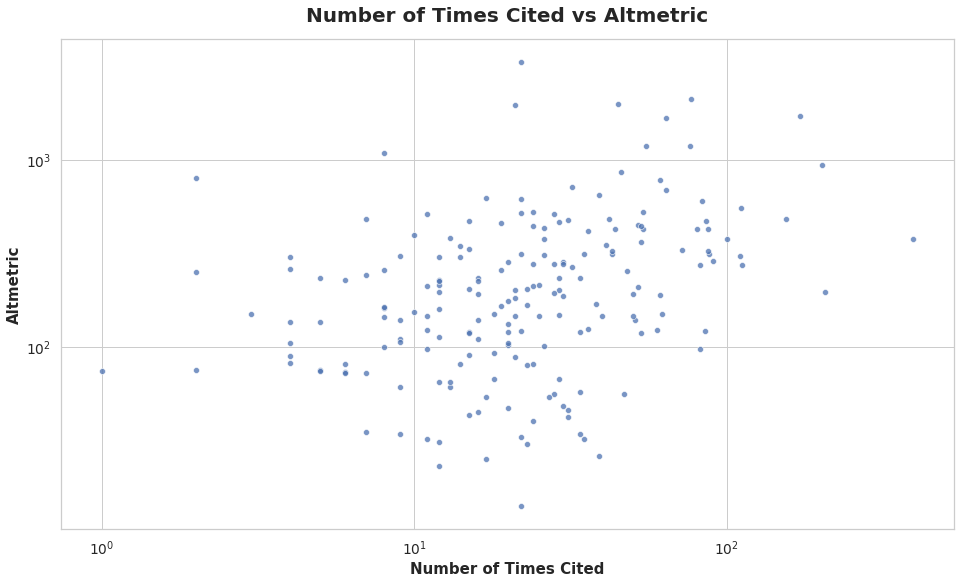

In [1876]:
plt.figure(figsize= (16,9))
sns.set_style("whitegrid")
ax = sns.scatterplot(df['num_times_cited'], df['altmetric'], alpha = 0.75)
ax.set(xscale="log", yscale="log");
plt.xlabel(xlabel='Number of Times Cited', y=1.25, fontsize = 15, weight= 'bold')
plt.ylabel(ylabel='Altmetric', x=1.05, fontsize = 15, weight = 'bold')
plt.title(label = 'Number of Times Cited vs Altmetric', fontsize = 20, y = 1.025, weight='bold' )
plt.savefig("Cited_vs_Altmetric.png")